<h1>Generating Human Faces with Generative Adversarial Networks</h1>

In this Project, artificial Human Faces are generated with the help of Generative Deep Learning. <b>Wasserstein Generative  Adversarial Networks <em>(WGAN)</em></b> is a version of GAN which improves the stability in data re-construction of the GAN and has a revised version of the <em>loss function</em> which correlates with the quality of the generated output.

In this project, the <b><em><a href='https://www.kaggle.com/datasets/jessicali9530/celeba-dataset/code'>CelebFaces Attributes (CelebA) Dataset</a></em></b> is used to train a <em>WGAN</em> to generate artificial human faces. <br>

However the dataset in use may not be perfect as most of the images of faces are of individuals of North American origin - who have a predominant fair complexion (as reflected in the dataset). <b><a href="https://openaccess.thecvf.com/content/WACV2021/papers/Karkkainen_FairFace_Face_Attribute_Dataset_for_Balanced_Race_Gender_and_Age_WACV_2021_paper.pdf">FairFace</a></b> may be a more diverse dataset of human faces with close-to equitable distribution in representation of human faces across various regions of the world. <b>FairFace</b> will be explored in a future version of this work.
<br>

<hr style="border: 1px double gray;"></hr>

Inorder to ensure the stability of the reconstructed images the following steps have been taken in the project:

* <em>Implementation of <b>Wasserstein Loss</b> instead of BCE-Loss to overcoms problems like 'flat-gradients', 'mode collapse' (Generator only reproduces a single instance which has the highest probability of circumventing the Critic).</em>

* <em>Enforce <b>'1-Lipschitz Continuity'</b> Condition on the Critic network and Penalizing the Gradients to limit imbalances between the Generator & Critic networks.</em>

This notebook is primarily involved in developing the associated methods to aid in building the <b><em>WGAN</em></b> & training the model.

<hr style="border: 4px double blue;"></hr>

<h3>Importing Relevant Modules & Libraries</h3>

In [1]:
import torch, os, PIL, pdb, torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
import numpy as np
from tqdm.auto import tqdm
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

import time
import sys

# Import WGAN Generator & Critic Model-Architecture Definition Modules
sys.path.append("./WGAN")

from WGAN.Generator import Generator
from WGAN.Critic import Critic

In [4]:
!nvidia-smi

Thu Jun 30 21:22:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.01       Driver Version: 516.01       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   67C    P8     5W /  N/A |      0MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

<h4>Define Hyper-parameters of the WGAN model</h4>

In [7]:
# HYPER-PARAMS 
num_epochs = 10 #10000
batch_size = 256 # 128
learning_rate = 1e-4
latent_dimension = 256
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

current_batch = 0

"""
    Alternative method of Training Critic & Generator.
    
       Critic is trained for 'critic_steps' number of epochs after which the
       Generator is trained. That is, for every 'critic_steps'- number of train-iterations,
       the Genreator is trained. This is done so that the Critic is trained to be a bit more
       resilient from being duped by the Generator in the WGAN architecture thereby, not being
       over-powered by the Generator easily.
       
       This Adversarial game in turn builds a stronger Generator Model - which is capable of creating
       high-quality representations.
"""

critic_steps = 5
generator_losses = []
critic_losses = []

log_steps = 150 # Number of Steps in Epoch after which model stats logged
checkpoint_epochs = 1 # Number of epochs after which we save the trained model

<h4>Define Helper Routines for training the WGAN</h4>

In [6]:
def data_sample_display( data_tensor, sample_size=16, name=''):
    """
        Take a peek at a sample of the dataset.
    """
    # Detach the Data Tensor & put to CPU
    data = data_tensor.detach().cpu()
    
    # To obtain grid view - permute tensor to get channel dim at the end with the
    # 'height' & 'width' of image at the beginning
    grid_view = make_grid(data[:sample_size], nrow= 4).permute(1,2,0)

    plt.imshow(grid_view.clip(0, 1))
    plt.show()

In [8]:
def latent_noise_create( num_batches=1, latent_dims=256,
                         device="cuda:0" if torch.cuda.is_available() else "cpu"
                       ):
    """
        Generate Noisy Latent Space Tensor to initialize the Generator. 
    """
    return torch.randn(num_batches, latent_dims, device=device)


<h4>Initialization of the WGAN Layers</h4>

In [9]:
# initialize the weights of the layers of the NN
def init_layers(layer):

    # initialise the Convolutional Layer's weights
    if isinstance(layer, torch.nn.Conv2d) or isinstance(layer, torch.nn.ConvTranspose2d):

        # initalize layer weights with stochastic sampling method from std normal dist - mean 0.0 & std 0.02 
        torch.nn.init.normal_(layer.weight, 0, 0.02) 
        # initialise layer bias with constant value
        torch.nn.init.constant_(layer.bias, 0) 

    # initialize batchNorm2d Layers weights & biases
    if isinstance(layer, torch.nn.BatchNorm2d):

        torch.nn.init.normal_(layer.weight, 0, 0.02) 
        torch.nn.init.constant_(layer.bias, 0) 


# critic_model = critic_model.apply(init_layers)
# generator_model = generator_model.apply(init_layers)

<hr style="border: 3px double gray;"></hr>

<h3>Inspect the Dataset</h3>

Define a Class Module to instantiate the dataset - to ease in definition of DataLoaders and to inpsect samples of data.

In [10]:
"""
CelebA dataset: 
    Source Website: https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html
    url = "https://drive.google.com/uc?id=1cNIac61PSA_LqDFYFUeyaQYekYPc75NH
"""

# Create a data loader to load the relevant dataset 
class celebA_dataset(Dataset):
    def __init__(self, path, img_size=128, data_size=10000):
        """
            Initialise with an object instantiation of a
            sample of the dataset.
        """
        self.img_dims = [img_size, img_size]
        self.data_items = []
        self.data_labels = []
        
        for data in os.listdir(path)[:data_size]:
            data_item = os.path.join(path, data)
            self.data_items.append( data_item )
            self.data_labels.append( data )
    
    def __len__(self):
        """
            Return the length of the data sample
        """
        return len(self.data_items)
    
    def __getitem__(self, idx):
        """
            Return a sample of Data in a compatible torch.Tensors ~ format
            which can be used by the NN.
        """
        # load the image data as a PIL object
        data = PIL.Image.open(self.data_items[idx]).convert('RGB') # dim: [178, 218]
        
        # convert to numpy Array -> also resize the images to appropriate dimension as defined while instantiating object
        data = np.asarray( torchvision.transforms.Resize(self.img_dims)(data) ) # dim: [128, 128, 3]
        
        # current dim PIL-convert-np.ndarray: width X height X channels
        # We require dimensions as - (channels, width, height) ~ which is compatible with Pytorch
        data = np.transpose(data, (2, 0, 1)).astype(np.float32, copy=False) # dim = [3, 128, 128])
        
        data = torch.from_numpy(data).div(255) # convert to Torch Tensor & normalize the image tensors
        
        return data, self.data_labels[idx]

In [8]:
path = "./data/img_align_celeba"

# Instantiate a dataset object -> Take a sample of 100,000 images.
dataset = celebA_dataset(path, img_size=128, data_size=100000)

# instantiate the dataloader from the dataloader
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

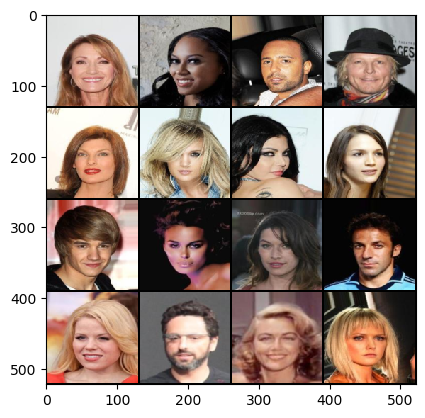

In [17]:
# Inspect a sample of the dataset.
X_img, y = next(iter(data_loader))
data_sample_display(X_img)

<h3>Define the Generator & Critic Model Objects & Prepare to Train the Networks</h3>

In [18]:
# Instantiate the Generator & Critic Networks of WGAN
gen_model = Generator(latent_space_dim=latent_dimension).to(device)
critic_model = Critic().to(device)

# Define the Optimization Algorithms of the Models.
gen_optim = torch.optim.Adam(gen_model.parameters(), lr=learning_rate, betas=(0.5,0.9))
critic_optim = torch.optim.Adam(critic_model.parameters(), lr=learning_rate, betas=(0.5,0.9))

In [19]:
print("Number of Trainable Params in -> Generator: {} | Critic: {}".format(
                                                    sum([ params.numel() for params in gen_model.parameters()]),
                                                    sum([ params.numel() for params in critic_model.parameters()]),
                                                    )
     )  

Number of Trainable Params in -> Generator: 4886947 | Critic: 701681


<h4>Prevent imbalance between the Generator & the Critic Networks of the WGAN by including Gradient-Penalty Schemes</h4>

In [11]:
# Define the Gradient Penalty for training the Models
def penalty(authentic_data, synthetic_data, critic_model, alpha, gamma=10):
    """
        ENFORCE 1-Lipshitz Condition of Contiuity for the Crtic Netwrok of WGAN.
            The condition is as follows: 
             - The norm of the Critic Should be 1 or less at each point in the feature space
             
        Also, we enforce Weight Clipping & Gradient Penalty.
        
        here, we enforce a L2-Regularization i.e. L2-Norm on the Critic Gradients.
    """
    interpolated_tensor = authentic_data*alpha + (1-alpha)*synthetic_data
    interpolated_score = critic_model(interpolated_tensor)
    
    # compute the sum of gradients of the output tensor wrt input tensor
    computed_gradients = torch.autograd.grad( inputs=interpolated_tensor,
                                              outputs=interpolated_score,
                                              grad_outputs=torch.ones_like(interpolated_score),
                                              retain_graph=True,
                                              create_graph=True
                                            )
    computed_gradients = computed_gradients[0] # dims: ['batch_size' X 3 X 128 X 128] -> 128 being the dims of resized img.
    
    # we want the dims as ['batch-size' X 'all-remaining-dims-product'] ~ 2D Tensor
    computed_gradients = computed_gradients.view(len(computed_gradients), -1) # Dims: ['batch_size' X 49152]
    computed_gradient_norm = computed_gradients.norm(2, dim=1) # use L2 norm
    
    gradient_penalty = gamma*((computed_gradient_norm-1)**2).mean()
    
    return gradient_penalty

<h4>Checkpoint Saving & Loading Method definitions</h4>

In [12]:
%matplotlib inline

# Create method for checkpoints
chkpt_path = './models/'

def checkpoint_model(chkpt_path, epoch, gen_model, gen_optimizer,
                     critic_model, critic_optimizer
                    ):
    # Save the Generator Model
    torch.save({
                'epoch': epoch,
                'generator_model_state_dict': gen_model.state_dict(),
                'generator_optimizer_state_dict': gen_optimizer.state_dict(),
                },
                chkpt_path+'Generator_{}.pth'.format(epoch)
              )
    
    # Save the Critic Model
    torch.save({
                'epoch': epoch,
                'critic_model_state_dict': critic_model.state_dict(),
                'critic_optimizer_state_dict': critic_optimizer.state_dict(),
                },
                chkpt_path+'Critic_{}.pth'.format(epoch)
              )
    
    print("\n Check point saved for Epoch: ", epoch)
    
def load_checkpoint(epoch_number, device, learning_rate=1e-4):
    
    chkpt_path_name = './models/Generator_{}.pth'.format(epoch_number)
    checkpoint = torch.load(chkpt_path_name)
    
    generator_model = Generator().to(device)
    generator_optimizer = torch.optim.Adam( generator_model.parameters(),
                                            lr=learning_rate, betas=(0.5,0.9)
                                          )
    
    generator_model.load_state_dict(checkpoint['generator_model_state_dict'])
    generator_optimizer.load_state_dict(checkpoint['generator_optimizer_state_dict'])    
    

    chkpt_path_name = './models/Critic_{}.pth'.format(epoch_number)
    checkpoint = torch.load(chkpt_path_name)
    
    critic_model = Critic().to(device)
    critic_optimizer = torch.optim.Adam( critic_model.parameters(),
                                         lr=learning_rate, betas=(0.5,0.9)
                                       )
    
    critic_model.load_state_dict(checkpoint['critic_model_state_dict'])
    critic_optimizer.load_state_dict(checkpoint['critic_optimizer_state_dict'])
    
    print('Successfully loaded Checkpoint!')
    
    return ( generator_model, generator_optimizer, 
             critic_model, critic_optimizer
           )

<hr style="border: 4px double red;"></hr>

<h3>Train the WGAN - Generator & Critic Models</h3>


Display the Generated Data -> 


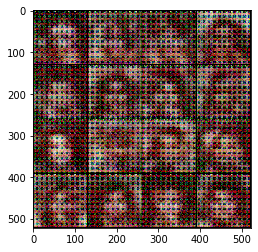

Epoch: 0 | Step: 150 | Losses over last 150 steps in epoch: Gen: 28.592857409119606 ~ Critic: -31.359596451997756


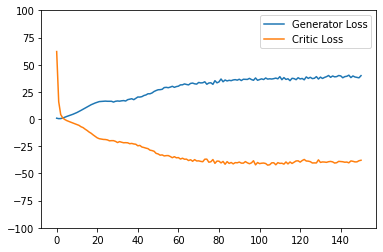


------------------------------------------------------------


Display the Generated Data -> 


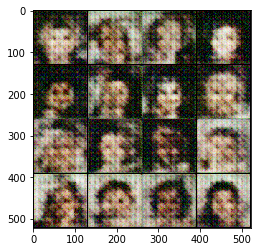

Epoch: 0 | Step: 300 | Losses over last 150 steps in epoch: Gen: 33.2564710744222 ~ Critic: -22.92039815266928


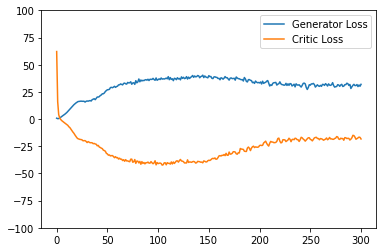


------------------------------------------------------------


Epoch: 0 ~ time taken: 61.22784988482793 min

 -- Saving GAN Models -- 

 Check point saved for Epoch:  1



Display the Generated Data -> 


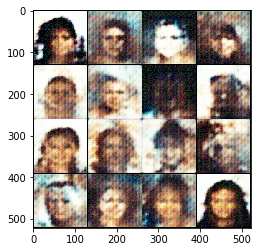

Epoch: 1 | Step: 150 | Losses over last 150 steps in epoch: Gen: 30.496310691833497 ~ Critic: -14.316097507476803


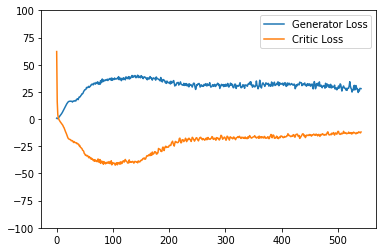


------------------------------------------------------------


Display the Generated Data -> 


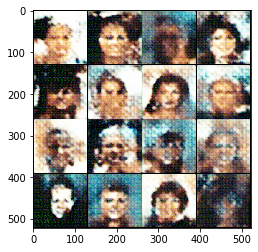

Epoch: 1 | Step: 300 | Losses over last 150 steps in epoch: Gen: 27.82377805074056 ~ Critic: -11.70597844314575


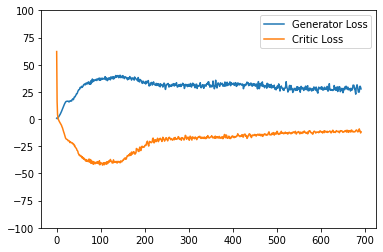


------------------------------------------------------------


Epoch: 1 ~ time taken: 72.26029428641002 min

 -- Saving GAN Models -- 

 Check point saved for Epoch:  2



Display the Generated Data -> 


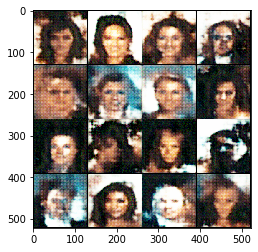

Epoch: 2 | Step: 150 | Losses over last 150 steps in epoch: Gen: 28.531123936971028 ~ Critic: -10.117776877085364


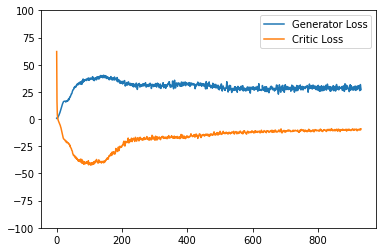


------------------------------------------------------------


Display the Generated Data -> 


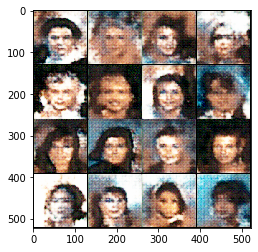

Epoch: 2 | Step: 300 | Losses over last 150 steps in epoch: Gen: 28.02515693664551 ~ Critic: -9.4192021446228


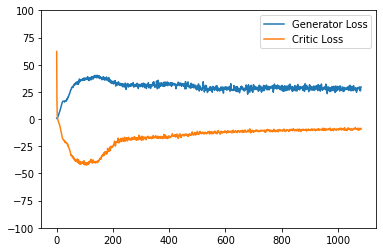


------------------------------------------------------------


Epoch: 2 ~ time taken: 54.37159310976664 min

 -- Saving GAN Models -- 

 Check point saved for Epoch:  3



Display the Generated Data -> 


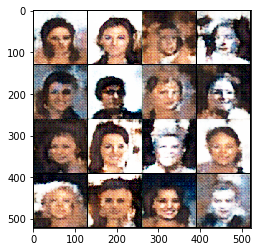

Epoch: 3 | Step: 150 | Losses over last 150 steps in epoch: Gen: 26.114897168477377 ~ Critic: -8.661810122807823


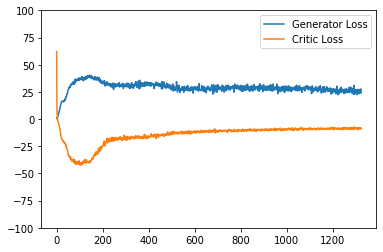


------------------------------------------------------------


Display the Generated Data -> 


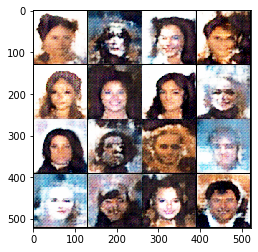

Epoch: 3 | Step: 300 | Losses over last 150 steps in epoch: Gen: 24.87863530476888 ~ Critic: -8.272642379124958


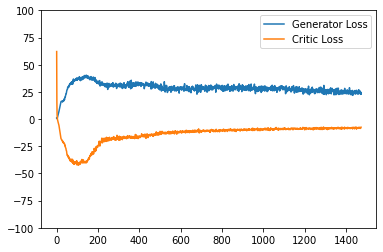


------------------------------------------------------------


Epoch: 3 ~ time taken: 55.67348378101985 min

 -- Saving GAN Models -- 

 Check point saved for Epoch:  4



Display the Generated Data -> 


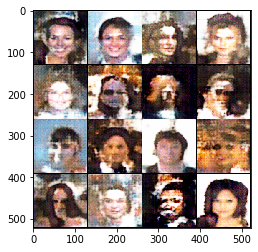

Epoch: 4 | Step: 150 | Losses over last 150 steps in epoch: Gen: 21.82496508280436 ~ Critic: -7.668354199091589


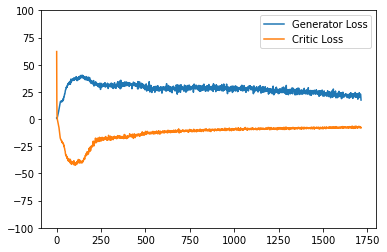


------------------------------------------------------------


Display the Generated Data -> 


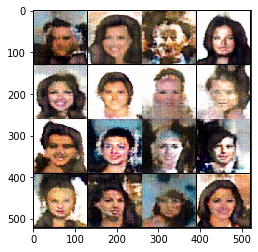

Epoch: 4 | Step: 300 | Losses over last 150 steps in epoch: Gen: 20.920491269429526 ~ Critic: -7.350013161977135


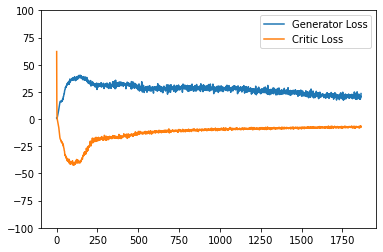


------------------------------------------------------------


Epoch: 4 ~ time taken: 56.9982448776563 min

 -- Saving GAN Models -- 

 Check point saved for Epoch:  5



Display the Generated Data -> 


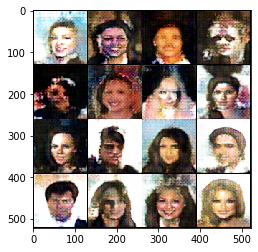

Epoch: 5 | Step: 150 | Losses over last 150 steps in epoch: Gen: 19.623261229197183 ~ Critic: -6.787640709877011


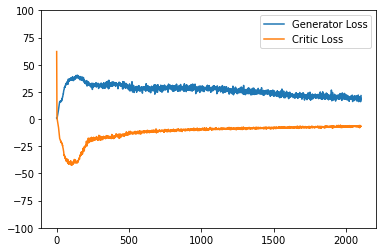


------------------------------------------------------------


Display the Generated Data -> 


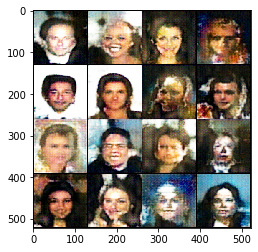

Epoch: 5 | Step: 300 | Losses over last 150 steps in epoch: Gen: 18.68977745056152 ~ Critic: -6.418262008984883


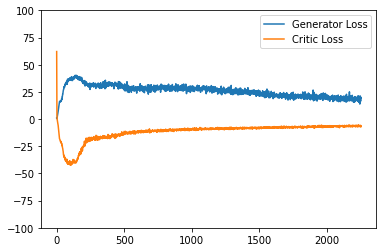


------------------------------------------------------------


Epoch: 5 ~ time taken: 55.96335020462672 min

 -- Saving GAN Models -- 

 Check point saved for Epoch:  6



Display the Generated Data -> 


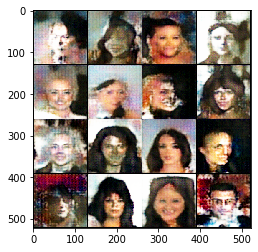

Epoch: 6 | Step: 150 | Losses over last 150 steps in epoch: Gen: 17.702602195739747 ~ Critic: -6.106864391326906


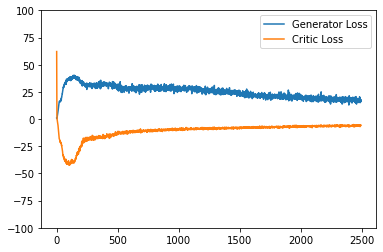


------------------------------------------------------------


Display the Generated Data -> 


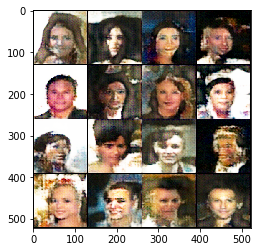

Epoch: 6 | Step: 300 | Losses over last 150 steps in epoch: Gen: 16.8081036567688 ~ Critic: -5.8541217581431075


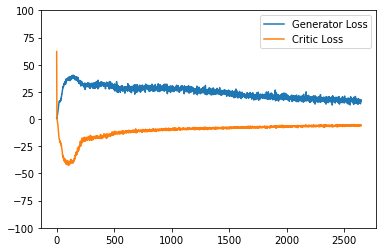


------------------------------------------------------------


Epoch: 6 ~ time taken: 56.27581808964411 min

 -- Saving GAN Models -- 

 Check point saved for Epoch:  7


In [ ]:
current_cycle_in_epoch = 0

# Training Iteration Definition
for epoch in range(num_epochs):
    
    epoch_start = time.time()
    current_cycle_in_epoch = 0
    
    # Checkpoint Models
    if (epoch%checkpoint_epochs == 0) and (epoch > 0):
        
        print("\n -- Saving GAN Models -- ")
        checkpoint_model( './models/', epoch, gen_model, gen_optim,
                          critic_model, critic_optim
                        )
        
    for orig_data, _ in tqdm(data_loader):
        current_batch_size = len(orig_data) # Current batch's bath_size
        orig_data = orig_data.to(device)
        
        # Train the Critic Model
        mean_critic_loss = 0
        
        """
            Training Scheme -> 
                For every single train iteration of the 'Generator' model we
                Train the Critic by 'critic_steps' number of iterations in each
                single Epoch.
        """
        
        for _ in range(critic_steps):
            critic_optim.zero_grad()
            
            # generate Noise as input to the Generator Model
            noise_data = latent_noise_create( current_batch_size, device=device )
            artificial_data = gen_model(noise_data)
            
            # dont update param of Generator while training the Critic
            artificial_data_preds = critic_model( artificial_data.detach() )
            
            # Critic Predictions for original data
            orig_data_preds = critic_model(orig_data)
            
            # compute the Gradient penalty for the Critic
            # get Alpha values (random) to compute the interpolation vector for penalty
            # Generate 'batch_size' equivalent random value for Alpha
            alpha = torch.rand(len(orig_data), 1, 1, 1, device=device, requires_grad=True)
            
            critic_gradient_penalty = penalty( orig_data, artificial_data.detach(),
                                               critic_model, alpha
                                             )
            
            # compute the Critic Loss also including the gradient penalties.
            critic_loss=artificial_data_preds.mean()-orig_data_preds.mean()+critic_gradient_penalty
            
            # .item() ~ to extract numeric value from tensor
            mean_critic_loss += critic_loss.item() / critic_steps # fraction of cycle for each of the loss values

            # perform back-propagation
            critic_loss.backward(retain_graph=True)
            # update parameters of the Critic with the ccomputed gradients
            critic_optim.step()
            
        # collect the critic losses
        critic_losses.append(mean_critic_loss)
        
        # Training the Generator model
        gen_optim.zero_grad()
        
        noise_data = latent_noise_create( current_batch_size, device=device )
        
        # pass the Noise-data to the generator & Generator output to the Critic
        generated_data = gen_model(noise_data)
        critic_preds = critic_model(generated_data)
        
        # Generator Loss
        generator_loss = -critic_preds.mean()
        generator_loss.backward()
        
        # Update params of Generator with the computed gradients
        gen_optim.step()
        
        # Collect the Generator Loss
        generator_losses.append( generator_loss.item() )
        
        # Log the Stats of the Model
        if (current_cycle_in_epoch%log_steps==0) and (current_cycle_in_epoch > 0):
            
            print("\nDisplay the Generated Data -> ")
            data_sample_display(generated_data)
            
            gen_mean_loss = sum(generator_losses[-log_steps:])/log_steps
            critic_mean_loss = sum(critic_losses[-log_steps:])/log_steps
            
            print("Epoch: {} | Step: {} | Losses over last {} steps in epoch: Gen: {} ~ Critic: {}".format(
                                                                                     epoch,
                                                                                     current_cycle_in_epoch,
                                                                                     log_steps, 
                                                                                     gen_mean_loss,
                                                                                     critic_mean_loss
                                                                                    )
                 )
            
            plt.plot(range(len(generator_losses)), generator_losses, label="Generator Loss")
            plt.plot(range(len(critic_losses)), critic_losses, label="Critic Loss")
            
            plt.ylim(-100, 100)
            plt.legend()
            plt.show()
            print("\n------------------------------------------------------------\n")
        
        current_cycle_in_epoch += 1
    
    # End of Epoch
    epoch_end = time.time()
    
    print("Epoch: {} ~ time taken: {} min".format(epoch, (epoch_end - epoch_start)/60))

<hr style="border: 3px double gray"></hr>

<h4>The Train Session was interrupted due to system issues -> Resuming Training from the stored model Checkpoint.</h4>

In [11]:
# Loading from Latest Saved Checkpoint - Resuming Training From where it got interrupted
gen_model, gen_optim, critic_model, critic_optim = load_checkpoint(6, device)

Successfully loaded Checkpoint!


<h4>Resuming Training the WGAN model</h4>


Display the Generated Data -> 


Epoch: 0 | Step: 150 | Losses over last 150 steps in epoch: Gen: 9.908637965520223 ~ Critic: -3.8473593047459915


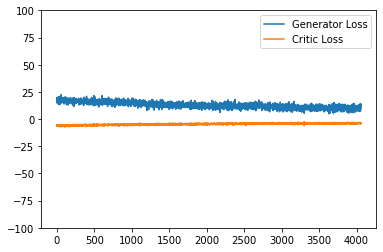


------------------------------------------------------------


Display the Generated Data -> 


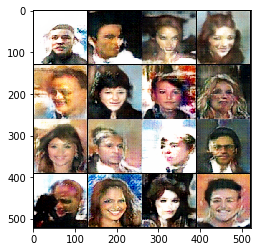

Epoch: 0 | Step: 300 | Losses over last 150 steps in epoch: Gen: 9.760226039886474 ~ Critic: -3.7706504931449913


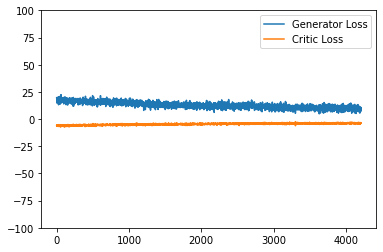


------------------------------------------------------------


Epoch: 0 ~ time taken: 45.11120058695475 min

 -- Saving GAN Models -- 

 Check point saved for Epoch:  1



Display the Generated Data -> 


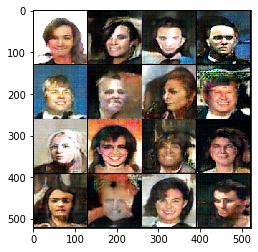

Epoch: 1 | Step: 150 | Losses over last 150 steps in epoch: Gen: 9.44003721555074 ~ Critic: -3.74657660404841


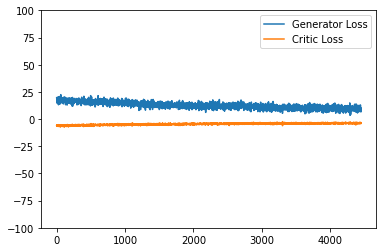


------------------------------------------------------------


Display the Generated Data -> 


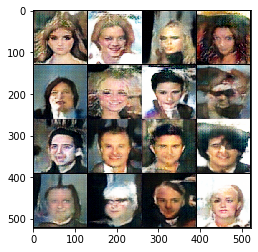

Epoch: 1 | Step: 300 | Losses over last 150 steps in epoch: Gen: 8.879487816492716 ~ Critic: -3.682291328430175


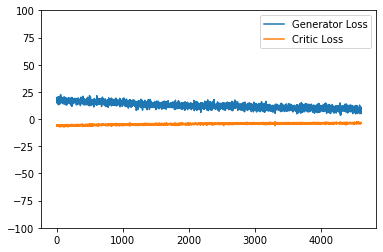


------------------------------------------------------------


Epoch: 1 ~ time taken: 58.90481868982315 min

 -- Saving GAN Models -- 

 Check point saved for Epoch:  2



Display the Generated Data -> 


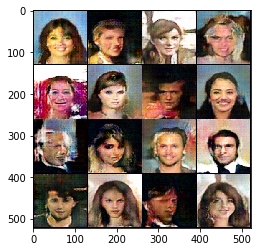

Epoch: 2 | Step: 150 | Losses over last 150 steps in epoch: Gen: 8.014720470110575 ~ Critic: -3.634781172275544


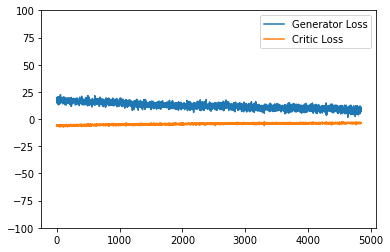


------------------------------------------------------------


Display the Generated Data -> 


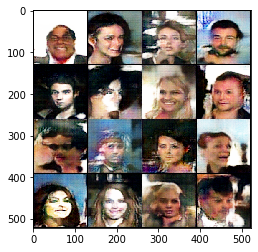

Epoch: 2 | Step: 300 | Losses over last 150 steps in epoch: Gen: 7.966234510739644 ~ Critic: -3.5693393840789795


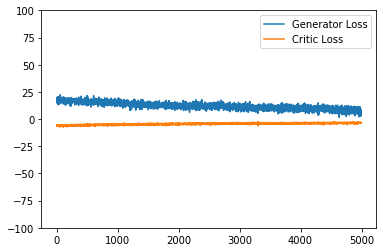


------------------------------------------------------------


Epoch: 2 ~ time taken: 60.132043691476184 min

 -- Saving GAN Models -- 

 Check point saved for Epoch:  3



Display the Generated Data -> 


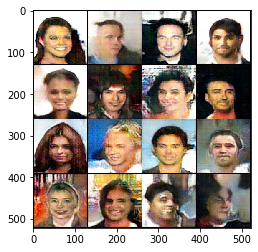

Epoch: 3 | Step: 150 | Losses over last 150 steps in epoch: Gen: 7.720362656911214 ~ Critic: -3.555103512922922


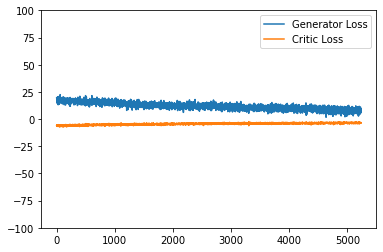


------------------------------------------------------------


Display the Generated Data -> 


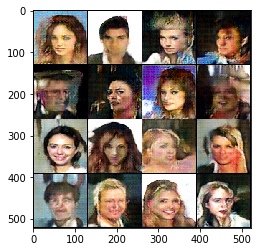

Epoch: 3 | Step: 300 | Losses over last 150 steps in epoch: Gen: 7.2687324587504065 ~ Critic: -3.5103733298778534


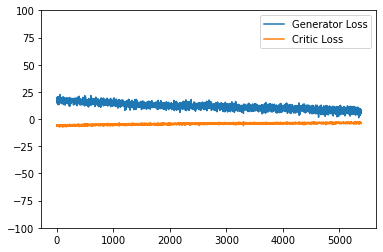


------------------------------------------------------------


Epoch: 3 ~ time taken: 57.27138907114665 min

 -- Saving GAN Models -- 

 Check point saved for Epoch:  4



Display the Generated Data -> 


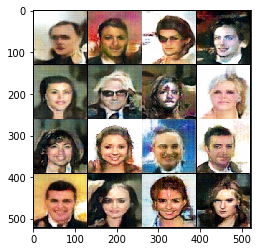

Epoch: 4 | Step: 150 | Losses over last 150 steps in epoch: Gen: 6.983338079452515 ~ Critic: -3.449440392494201


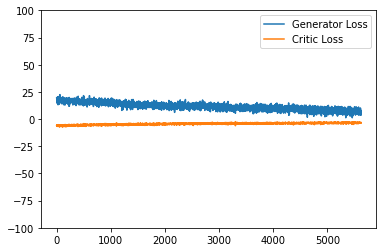


------------------------------------------------------------


Display the Generated Data -> 


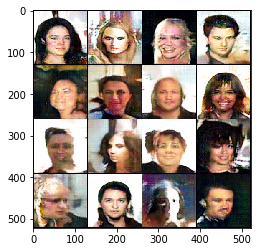

Epoch: 4 | Step: 300 | Losses over last 150 steps in epoch: Gen: 6.846567594210307 ~ Critic: -3.387752116362252


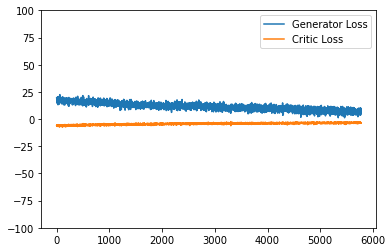


------------------------------------------------------------


Epoch: 4 ~ time taken: 53.38595573107401 min


In [16]:
# Training Interrrupted - Restarting from a saved Checkpoint...
current_cycle_in_epoch = 0
num_epochs = 5

for epoch in range(num_epochs):
    
    epoch_start = time.time()
    current_cycle_in_epoch = 0
    
    # Checkpoint Models
    if (epoch%checkpoint_epochs == 0) and (epoch > 0):
        
        print("\n -- Saving GAN Models -- ")
        checkpoint_model( './models/', epoch, gen_model, gen_optim,
                          critic_model, critic_optim
                        )
        
    for orig_data, _ in tqdm(data_loader):
        current_batch_size = len(orig_data) # Current batch's bath_size
        orig_data = orig_data.to(device)
        
        # Train the Critic Model
        mean_critic_loss = 0
        
        """
            Training Scheme -> 
                For every single train iteration of the 'Generator' model we
                Train the Critic by 'critic_steps' number of iterations in each
                single Epoch.
        """
        
        for _ in range(critic_steps):
            critic_optim.zero_grad()
            
            # generate Noise as input to the Generator Model
            noise_data = latent_noise_create( current_batch_size, device=device )
            artificial_data = gen_model(noise_data)
            
            # dont update param of Generator while training the Critic
            artificial_data_preds = critic_model( artificial_data.detach() )
            
            # Critic Predictions for original data
            orig_data_preds = critic_model(orig_data)
            
            # compute the Gradient penalty for the Critic
            # get Alpha values (random) to compute the interpolation vector for penalty
            # Generate 'batch_size' equivalent random value for Alpha
            alpha = torch.rand(len(orig_data), 1, 1, 1, device=device, requires_grad=True)
            
            critic_gradient_penalty = penalty( orig_data, artificial_data.detach(),
                                               critic_model, alpha
                                             )
            
            # compute the Critic Loss also including the gradient penalties.
            critic_loss=artificial_data_preds.mean()-orig_data_preds.mean()+critic_gradient_penalty
            
            # .item() ~ to extract numeric value from tensor
            mean_critic_loss += critic_loss.item() / critic_steps # fraction of cycle for each of the loss values

            # perform back-propagation
            critic_loss.backward(retain_graph=True)
            # update parameters of the Critic with the ccomputed gradients
            critic_optim.step()
            
        # collect the critic losses
        critic_losses.append(mean_critic_loss)
        
        # Training the Generator model
        gen_optim.zero_grad()
        
        noise_data = latent_noise_create( current_batch_size, device=device )
        
        # pass the Noise-data to the generator & Generator output to the Critic
        generated_data = gen_model(noise_data)
        critic_preds = critic_model(generated_data)
        
        # Generator Loss
        generator_loss = -critic_preds.mean()
        generator_loss.backward()
        
        # Update params of Generator with the computed gradients
        gen_optim.step()
        
        # Collect the Generator Loss
        generator_losses.append( generator_loss.item() )
        
        # Log the Stats of the Model
        if (current_cycle_in_epoch%log_steps==0) and (current_cycle_in_epoch > 0):
            
            print("\nDisplay the Generated Data -> ")
            data_sample_display(generated_data)
            
            gen_mean_loss = sum(generator_losses[-log_steps:])/log_steps
            critic_mean_loss = sum(critic_losses[-log_steps:])/log_steps
            
            print("Epoch: {} | Step: {} | Losses over last {} steps in epoch: Gen: {} ~ Critic: {}".format(
                                                                                     epoch,
                                                                                     current_cycle_in_epoch,
                                                                                     log_steps, 
                                                                                     gen_mean_loss,
                                                                                     critic_mean_loss
                                                                                    )
                 )
            
            plt.plot(range(len(generator_losses)), generator_losses, label="Generator Loss")
            plt.plot(range(len(critic_losses)), critic_losses, label="Critic Loss")
            
            plt.ylim(-100, 100)
            plt.legend()
            plt.show()
            print("\n------------------------------------------------------------\n")
        
        current_cycle_in_epoch += 1
    
    # End of Epoch
    epoch_end = time.time()
    
    print("Epoch: {} ~ time taken: {} min".format(epoch, (epoch_end - epoch_start)/60))

In [17]:
# Save the Loss of the resumed training session 
np.savez("./losses/Losses_v2.0.npz", np.array([generator_losses, critic_losses]))

<hr style="border: 3px double gray;"></hr>

<h4>Inspect the Training Losses of both the Generator & Critic Networks of WGAN Model</h4>

In [2]:
# Load the Loss of the initial Training Session
critic_loss1 = pd.read_csv('./losses/Critic_Loss.csv')
generator_loss1 = pd.read_csv('./losses/Generator_Loss.csv')

In [3]:
# Load the Loss of the resumed training session 
losses2 = np.load("./losses/Losses_v2.0.npz")
losses2.files

['arr_0']

In [4]:
# Get the respective Generator & Critic losses
generator_loss2 = losses2['arr_0'][0]
critic_loss2 = losses2['arr_0'][1]

<h4>Collate respective Generator & Critic Losses for Visualizing the Trend in Loss over successive Train iterations</h4>

In [5]:
generator_loss2 = pd.DataFrame({"Iterations": [ 2700+i for i in range(len(generator_loss2))],
                                "Generator_Loss": generator_loss2
                               }
                              )

critic_loss2 = pd.DataFrame({"Iterations": [ 2700+i for i in range(len(critic_loss2))],
                             "Critic_Loss": critic_loss2
                            }
                           )

In [6]:
# Concatinating the stored losses over both the Training Sessions
generator_loss = pd.concat([generator_loss1, generator_loss2], axis=0)
critic_loss = pd.concat([critic_loss1, critic_loss2], axis=0)

<h3>Preview the Train-stats of the WGAN model</h3>

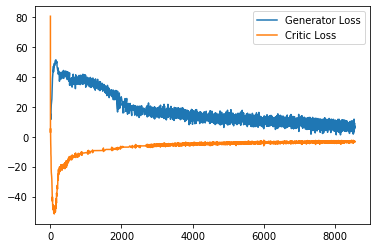

In [7]:
%matplotlib inline

plt.plot(generator_loss.Iterations, generator_loss.Generator_Loss, label="Generator Loss")
plt.plot(critic_loss.Iterations, critic_loss.Critic_Loss, label="Critic Loss")
plt.legend()
plt.show()